In [16]:
import numpy as np
import seaborn as sns
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    Activation,
)
import tensorflow as tf
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
non_vehicles = r"C:\Users\ah760\OneDrive\Desktop\Vehicle Detection\data\non-vehicles"
vehicles = r"C:\Users\ah760\OneDrive\Desktop\Vehicle Detection\data\vehicles"

In [7]:
def load_images(folder_path, img_size):
    images_names = os.listdir(folder_path)
    X = np.zeros((len(images_names), *img_size))
    for i, img_name in tqdm(enumerate(images_names)):
        try:
            img_array = cv2.imread(os.path.join(folder_path, img_name))
            img_array = cv2.resize(img_array, (img_size[0], img_size[1]))
            X[i] = img_array
        except:
            X[i] = X[i - 1]
    X = X / 255.0  # for normalizing the images
    return X

In [10]:
a1 = load_images(non_vehicles, (64, 64, 3))
a2 = load_images(vehicles, (64, 64, 3))
a1.shape, a2.shape

0it [00:00, ?it/s]

8968it [00:02, 3551.88it/s]
8792it [00:02, 3118.58it/s]


((8968, 64, 64, 3), (8792, 64, 64, 3))

In [11]:
label1 = np.ones(
    len(a1),
)
label2 = np.zeros(
    len(a2),
)
X = np.concatenate([a1, a2], axis=0)
y = np.concatenate([label1, label2], axis=0)

print("X shape : ", X.shape, "y shape : ", y.shape)

print("label1 shape : ", label1.shape, "label2 shape : ", label2.shape)

X shape :  (17760, 64, 64, 3) y shape :  (17760,)
label1 shape :  (8968,) label2 shape :  (8792,)


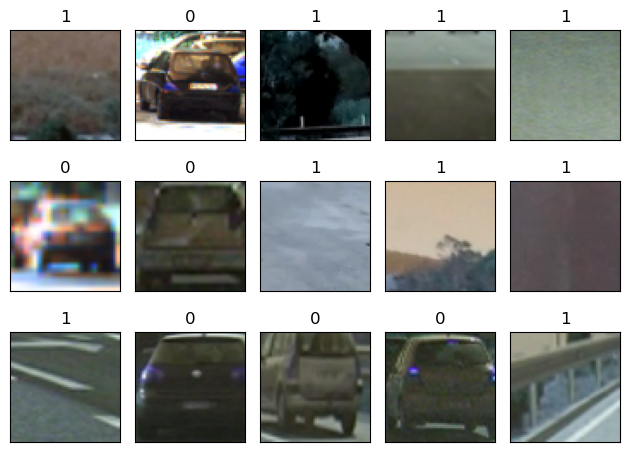

((15984, 64, 64, 3), (1776, 64, 64, 3), (15984,), (1776,))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=309
)
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(int(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()
X_train.shape, X_test.shape, y_train.shape, y_test.shape


In [18]:
model = Sequential(
    [
        # CNN for feature extraction
        Dense(64, activation="relu", input_shape=(64, 64, 3)),
        Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),
        Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),
        Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),
        Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),
        # Now i will flatten the output of the CNN
        Flatten(),
        # Dense layers for classification
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 112ms/step - accuracy: 0.8767 - loss: 0.2655
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 58s 116ms/step - accuracy: 0.9905 - loss: 0.0323
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 54s 108ms/step - accuracy: 0.9902 - loss: 0.0307
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 104ms/step - accuracy: 0.9945 - loss: 0.0194
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 104ms/step - accuracy: 0.9951 - loss: 0.0153


In [20]:
prob = model.predict(X_test)
y_pred = np.array([np.argmax(it) for it in prob])
cnn_acc = f1_score(y_pred, y_test, average="macro")
print("my CNN Model accuracy for test data = ",cnn_acc)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
my CNN Model accuracy for test data =  0.9876011500161839


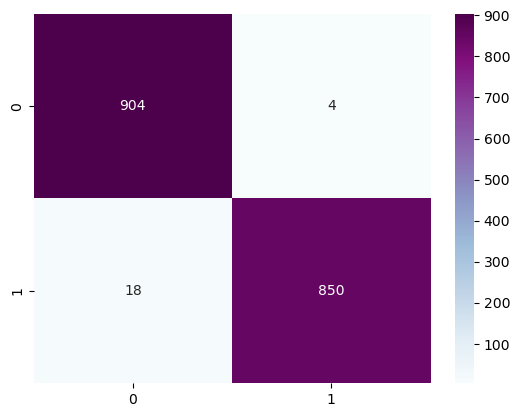

In [21]:
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt=".0f", cmap="BuPu")
plt.show()

In [26]:
resnet = tf.keras.applications.ResNet50(
    include_top=False,
)
resnet_model = Sequential(
    [
        resnet,
        Flatten(),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),        
        Dense(2, activation="softmax"),
    ]
)
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [27]:
resnet_model.fit(X_train, y_train, epochs=3)

Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 403s 734ms/step - accuracy: 0.9699 - loss: 0.0768
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 378s 756ms/step - accuracy: 0.9981 - loss: 0.0068
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 382s 764ms/step - accuracy: 0.9996 - loss: 0.0020


In [28]:
prob = resnet_model.predict(X_test)
y_pred = np.array([np.argmax(it) for it in prob])
res_acc = f1_score(y_pred, y_test, average="macro")
print("resnet Model accuracy for test data = ",res_acc)

56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step
resnet Model accuracy for test data =  0.998308545117051


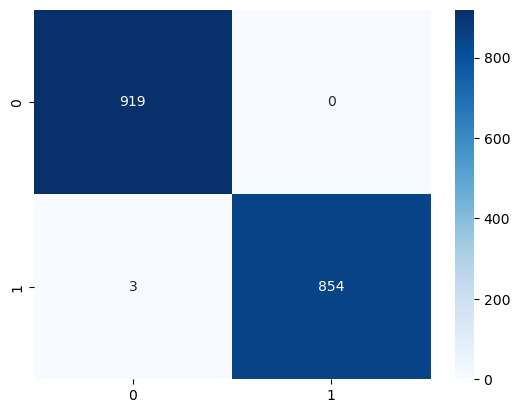

In [29]:
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt=".0f", cmap="Blues")
plt.show()

In [30]:
vgg = tf.keras.applications.VGG19(
    include_top=False,
)
vgg_model = Sequential(
    [
        vgg,
        Flatten(),
        Dense(128, activation="relu"),
        Dense(2, activation="softmax"),
    ]
)
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 48s 1us/step


In [31]:
vgg_model.fit(X_train, y_train, epochs=2)

Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - accuracy: 0.8181 - loss: 0.5357
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 479s 958ms/step - accuracy: 0.8777 - loss: 0.3602


In [32]:
prob = vgg_model.predict(X_test)
y_pred = np.array([np.argmax(it) for it in prob])
vgg_acc = f1_score(y_pred, y_test, average="macro")
print("vgg Model accuracy for test data = ",vgg_acc)

56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 236ms/step
vgg Model accuracy for test data =  0.9684627092846271


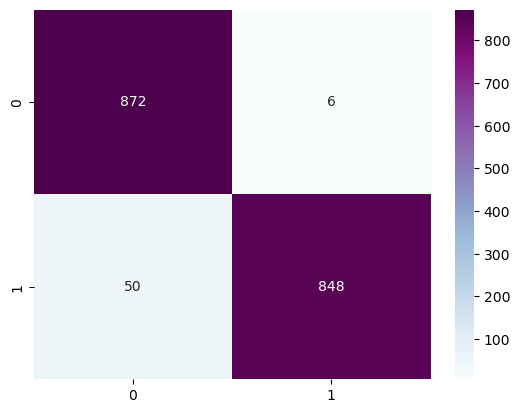

In [34]:
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt=".0f", cmap="BuPu")
plt.show()

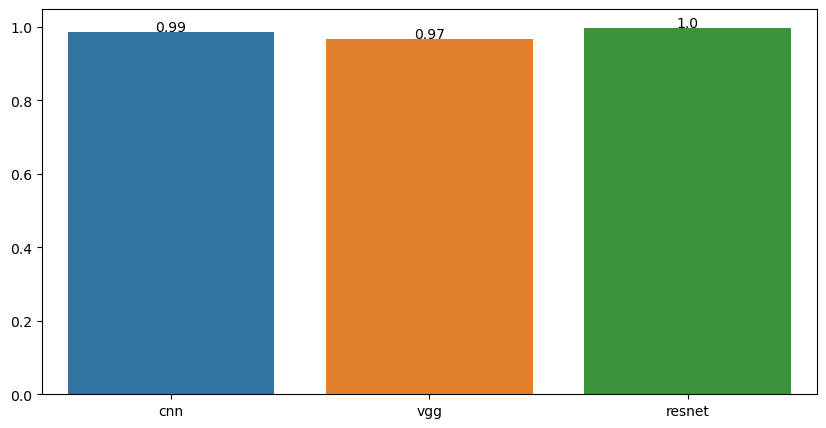

In [38]:
plt.figure(figsize=(10, 5))
sns.barplot(x=['cnn', 'vgg', 'resnet'], y=[cnn_acc, vgg_acc, res_acc])

# i will write the accuracy of the models on the top of the bars
for i in range(3):
    plt.text(i, [cnn_acc, vgg_acc, res_acc][i], round([cnn_acc, vgg_acc, res_acc][i], 2), ha = 'center')
